In [1]:
from triqs.gf import *
from triqs.operators import *
from triqs.operators.util.hamiltonians import h_int_kanamori, h_int_slater
from triqs.operators.util import *
from triqs.operators.util.hamiltonians import *

from h5 import HDFArchive
from triqs.atom_diag import *
import numpy as np
import sympy as sp
from itertools import product
import matplotlib.pylab as plt

In [19]:
# Definition of a 3-orbital atom
spin_names = ('up','dn')
orb_names = [0, 1]
beta = 1e24
target_occ = 2
U = 4.0
t = 1.0
eps = 1.0
mu = -12.0

C = np.sqrt(16 * t ** 2+U**2)
A = np.sqrt(2*(1+16*t**2 / ((C-U)**2)))
B = np.sqrt(2*(1+16*t**2 / ((C+U)**2)))

uijkl = np.zeros((2,2,2,2))
uijkl[0,0,0,0] = U
uijkl[1,1,1,1] = U

tij = np.zeros((2,2))
tij[0,1] = t
tij[1,0] = t

# Set of fundamental operators
fops = [(sn,on) for sn, on in product(spin_names,orb_names)]

# Numbers of particles with spin up/down
N_up = n('up',0) + n('up',1)
N_dn = n('dn',0) + n('dn',1)
N = N_up + N_dn

# Add chemical potential
H = mu * (N_up + N_dn)

# Add Coulomb
H += h_int_slater(spin_names, orb_names, uijkl, off_diag=True, complex=True)

# Add single partcle terms
for s, o1, o2 in product(spin_names, orb_names, orb_names):
    H += 0.5*(        tij[int(o1),int(o2)]  * c_dag(s,o1) * c(s,o2) + 
              np.conj(tij[int(o1),int(o2)]) * c_dag(s,o2) * c(s,o1))
    
    
################################
H = mu * (N_up + N_dn)
for s in spin_names:
    for i in range(len(orb_names)):
        H += -t*(c_dag(s, i)*c(s, (i+1)%len(orb_names)))
        
        
H += h_int_slater(spin_names, orb_names, uijkl, off_diag=True, complex=True)

for s in spin_names:
    for o in orb_names:
        H += eps*(n(s, o))


In [20]:
step = 0.01
while True:

    H += mu * N
    ad = AtomDiagComplex(H, fops, n_min=target_occ-1, n_max=target_occ+1)

    beta = 1e24
    dm = atomic_density_matrix(ad, beta)
    filling = trace_rho_op(dm, N, ad)

    if abs(filling.real-target_occ) < 1.0e-6:
        break
    elif filling.real < target_occ:
        H += -mu * N
        mu+=-step
    elif filling.real > target_occ:
        H += -mu * N
        mu+=step    
    
print("mu:", mu, "filling:", filling)

mu: 7.17999999999968 filling: (1.9999999999999996+0j)


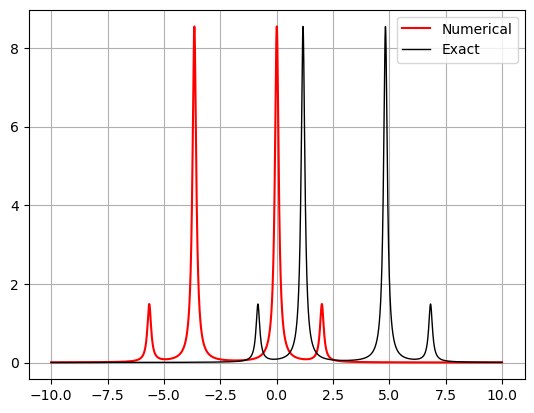

In [21]:
def G(i, j, w):
    eta = 0.1
    
    A1 = (1+4*t/(C-U))**2 / (w-(eps-t+(C+U)/2)+ eta * 1j)
    A2 = (-1)**(i-j)*(1-4*t/(C-U))**2 / (w-(eps+t+(C+U)/2)+ eta * 1j)
    
    B1 = (1+4*t/(C-U))**2 / (w-(eps+t-(C-U)/2)+eta * 1j)
    B2 = (-1)**(i-j)*(1-4*t/(C-U))**2 / (w-(eps-t-(C-U)/2)+eta * 1j)
    
    return ((-1)**(i-j)*(A1+A2) + B1 + B2) / (2*A**2)


gf_struct = [('dn', len(orb_names)),
             ('up', len(orb_names))]

G_w = atomic_g_w(ad, beta, gf_struct, (-10, 10), 10000, 0.1)
# print(G_w['up'].data[:,:,:][0])

f = np.array(list(G_w['up'].mesh.values()))



G_exact = np.zeros((10000, 2, 2)) * 1j


for k, W in enumerate(f):
    g = np.array([[G(1, 1, W), G(1, 2, W)], [G(2, 1, W), G(2, 2, W)]])
    G_exact[k] = g
plt.figure(1)
plt.clf()
plt.grid(True)

plt.plot(f, -np.imag(np.trace(G_w['up'].data[:,:,:], axis1=1, axis2=2)), color = 'red', label = 'Numerical') 
plt.plot(f, -np.imag(np.trace(G_exact, axis1=1, axis2=2)), color = 'black', lw = 1, label = 'Exact')
plt.legend()
plt.show()